<a href="https://colab.research.google.com/github/Tavo826/Aprende-ML-Book-/blob/main/DecisionTree.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Archivo con información de BillBoard, predicción artista #1

Características:

* title
* artist
* mood
* tempo
* genre
* artist_type
* chart_date
* durationSeg
* top (1 si alcanzó #1, 0 si no)
* anioNacimiento

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('ggplot')
from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold, cross_val_score
from IPython.display import Image as PImage
from subprocess import check_call
from PIL import Image, ImageDraw, ImageFont

In [ ]:
data = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Libro_AprendeML/artists_billboard_fix3.csv')
print(data.shape)
data.head()

(635, 11)


,id,title,artist,mood,tempo,genre,artist_type,chart_date,durationSeg,top,anioNacimiento
0,0,Small Town Throwdown,BRANTLEY GILBERT featuring JUSTIN MOORE & THOM...,Brooding,Medium Tempo,Traditional,Male,20140628,191.0,0,1975.0
1,1,Bang Bang,"JESSIE J, ARIANA GRANDE & NICKI MINAJ",Energizing,Medium Tempo,Pop,Female,20140816,368.0,0,1989.0
2,2,Timber,PITBULL featuring KE$HA,Excited,Medium Tempo,Urban,Mixed,20140118,223.0,1,1993.0
3,3,Sweater Weather,THE NEIGHBOURHOOD,Brooding,Medium Tempo,Alternative & Punk,Male,20140104,206.0,0,1989.0
4,4,Automatic,MIRANDA LAMBERT,Yearning,Medium Tempo,Traditional,Female,20140301,232.0,0,0.0


top
0    494
1    141
dtype: int64


/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


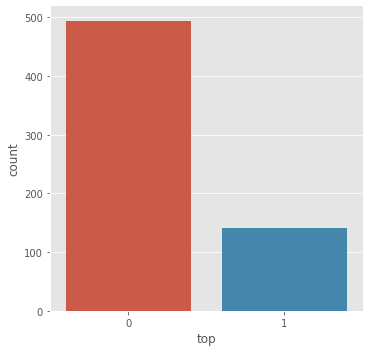

In [ ]:
#Agrupando para conocer cúantos alcanzaron el #1
print(data.groupby('top').size())

#Graficando
sb.factorplot('top',data=data ,kind="count")

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


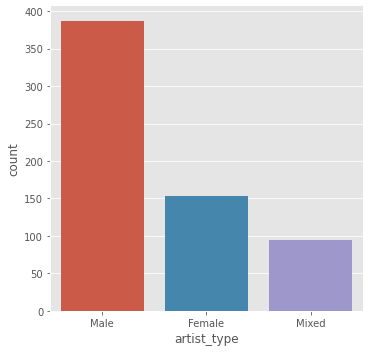

In [ ]:
#Tipos de artistas
sb.factorplot('artist_type', data=data, kind="count")

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


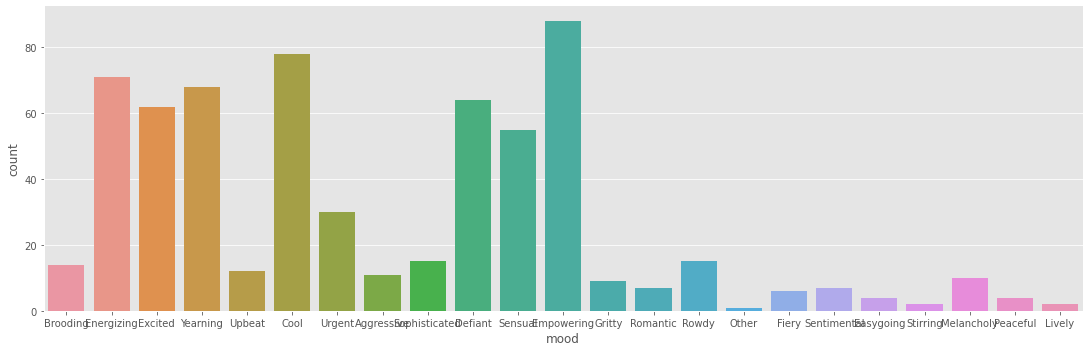

In [ ]:
#Mood o estado de ánimo
sb.factorplot('mood', data=data, kind='count', aspect=3)

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


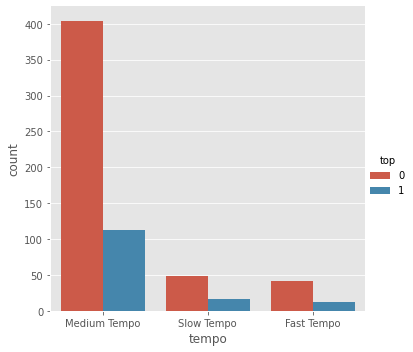

In [ ]:
#Tempo
sb.factorplot('tempo', data=data, hue='top', kind="count")

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


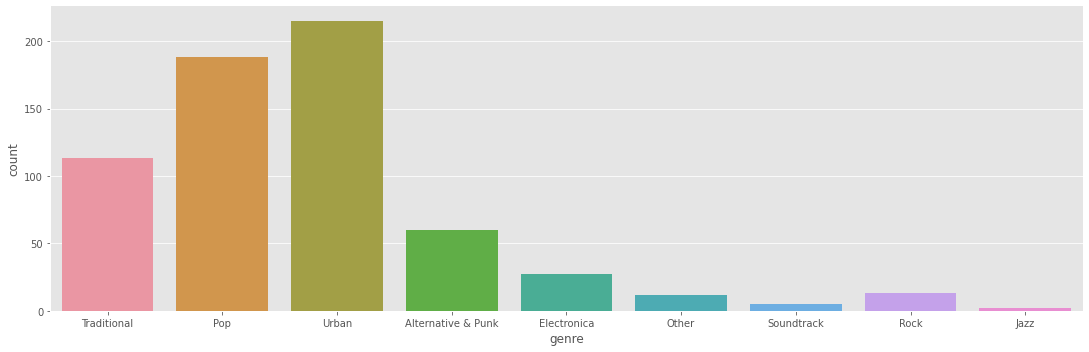

In [ ]:
#Género
sb.factorplot('genre', data=data, kind="count", aspect=3)

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


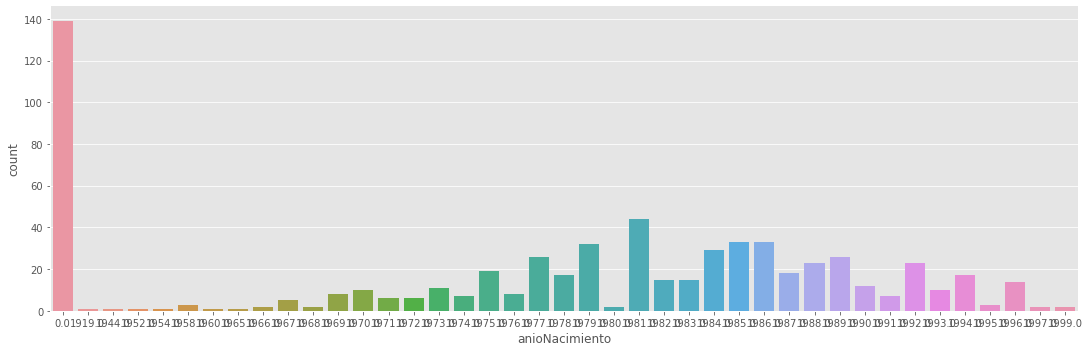

In [ ]:
#Año nacimiento del artista
sb.factorplot('anioNacimiento', data=data, kind="count", aspect=3)

#140 canciones de las cuales se desconoce el año de nacimiento del artista

## Balanceando datos

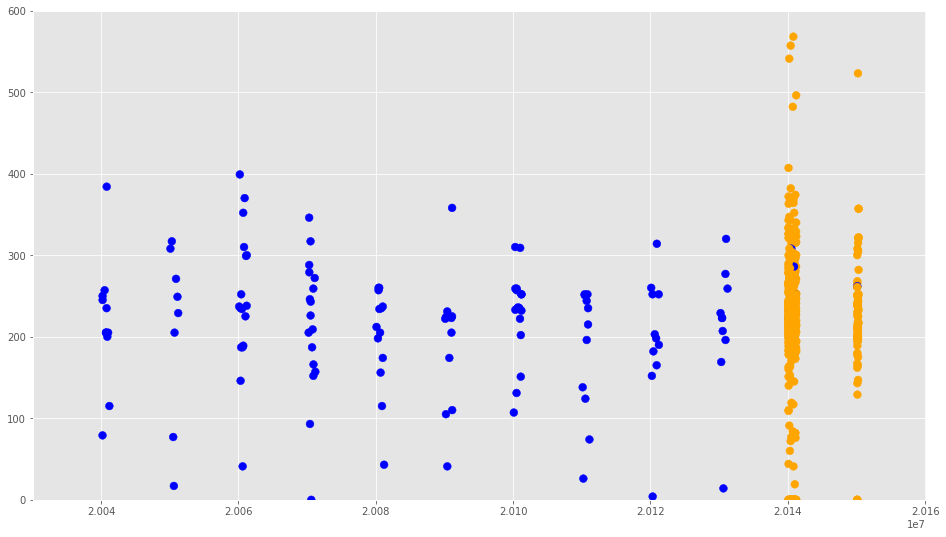

In [ ]:
#Visualizando 'top' y 'no-top' de acuerdo a las fechas en los Charts

f1 = data['chart_date'].values
f2 = data['durationSeg'].values

colores = ['orange', 'blue']
tamanios = [60, 40]

asignar = []
asignar2 = []
for index, row in data.iterrows():
  asignar.append(colores[row['top']])
  asignar2.append(tamanios[row['top']])

plt.scatter(f1, f2, c=asignar, s=tamanios[0])
plt.axis([20030101, 20160101, 0, 600])
plt.show()

## Preparando datos

In [ ]:
#Problemas en los años de nacimiento en 0

#Reemplazando 0 por None

def edad_fix(anio):
  if anio == 0:
    return None
  return anio

data['anioNacimiento'] = data.apply(lambda x: edad_fix(x['anioNacimiento']), axis=1)

#Calculando edad en BillBoard en una nueva columna

def calcula_edad(anio, cuando):
  cad = str(cuando)
  momento = cad[:4]
  if anio == 0.0:
    return None
  return int(momento) - anio

data['edad_en_billboard'] = data.apply(lambda x: calcula_edad(x['anioNacimiento'], x['chart_date']), axis=1)

#Se calcula el promedio de edad del conjunto (avg)
#Se calcula desvío estándar de la edad del conjunto (std)
#Se llenan los espacios en None con valores random [avg-std, avg+std] que viene a ser [21, 37]

age_avg = data['edad_en_billboard'].mean()
age_std = data['edad_en_billboard'].std()
age_null_count = data['edad_en_billboard'].isnull().sum()
age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_count)

conValoresNulos = np.isnan(data['edad_en_billboard'])

data.loc[np.isnan(data['edad_en_billboard']), 'edad_en_billboard'] = age_null_random_list
data['edad_en_billboard'] = data['edad_en_billboard'].astype(int)

print('Edad Promedio: ', str(age_avg))
print('Desviación Std Edad: ', str(age_std))
print('Intervalo: ' + str(int(age_avg - age_std)) + ' a ' + str(int(age_avg + age_std)))


Edad Promedio:  30.10282258064516
Desviación Std Edad:  8.40078832861513
Intervalo: 21 a 38


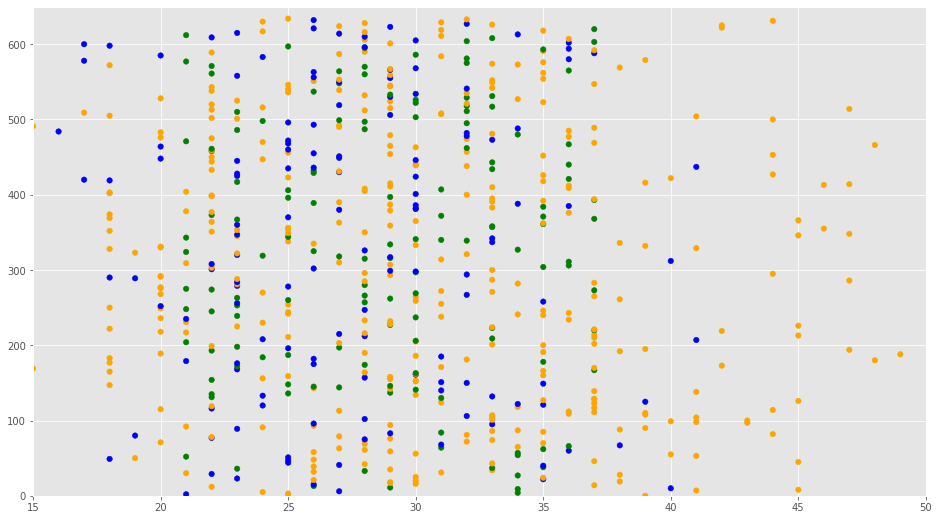

In [ ]:
#Visualizando valores agregados (verde)

f1 = data['edad_en_billboard'].values
f2 = data.index

colores = ['orange', 'blue', 'green']

asignar = []
for index, row in data.iterrows():
  if (conValoresNulos[index]):
    asignar.append(colores[2])
  else:
    asignar.append(colores[row['top']])

plt.scatter(f1, f2, c=asignar, s=30)
plt.axis([15, 50, 0, 650])
plt.show()

## Mapeo de datos

In [ ]:
#Transforma a categóricos
#edad_en_billboard, durationSeg, mood, tempo

#Mood Mapping
data['moodEncoded'] = data['mood'].map({'Energizing': 6,
                                        'Empowering': 6,
                                        'Cool': 5,
                                        'Yearning': 4,
                                        'Excited': 5,
                                        'Defiant': 3,
                                        'Sensual': 2,
                                        'Gritty': 3,
                                        'Sophisticated': 4,
                                        'Aggressive': 4,
                                        'Fiery': 4,
                                        'Urgent': 3,
                                        'Rowdy': 4,
                                        'Sentimental': 4,
                                        'Easygoing': 1,
                                        'Melancholy': 4,
                                        'Romantic': 2,
                                        'Peaceful': 1,
                                        'Brooding': 4,
                                        'Upbeat': 5,
                                        'Stirring': 5,
                                        'Lively': 5,
                                        'Other': 0, '': 0}).astype(float)                                     

#Tempo Mapping
data['tempoEncoded'] = data['tempo'].map({'Fast Tempo': 0,
                                          'Medium Tempo': 2,
                                          'Slow Tempo': 1, '': 0}).astype(int)

#Genre Mapping
data['genreEncoded'] = data['genre'].map({'Urban': 4,
                                          'Pop': 3,
                                          'Traditional': 2,
                                          'Alternative & Punk': 1,
                                          'Electronica': 1,
                                          'Rock': 1,
                                          'Soundtrack': 0,
                                          'Jazz': 0,
                                          'Other': 0, '': 0}).astype(int)

#astist_type Mapping
data['artist_typeEncoded'] = data['artist_type'].map({'Female': 3,
                                                      'Male': 2,
                                                      'Mixed': 1, '': 0}).astype(int)

#edad_en_billboard Mapping
data.loc[data['edad_en_billboard'] <= 21, 'edadEncoded'] = 0
data.loc[(data['edad_en_billboard'] > 21) & (data['edad_en_billboard'] <= 26), 'edadEncoded'] = 1
data.loc[(data['edad_en_billboard'] > 26) & (data['edad_en_billboard'] <= 30), 'edadEncoded'] = 2
data.loc[(data['edad_en_billboard'] > 30) & (data['edad_en_billboard'] <= 40), 'edadEncoded'] = 3
data.loc[data['edad_en_billboard'] > 40, 'edadEncoded'] = 4

#Mapping Song Duration
data.loc[data['durationSeg'] <= 150, 'durationEncoded'] = 0
data.loc[(data['durationSeg'] > 150) & (data['durationSeg'] <= 180), 'durationEncoded'] = 1
data.loc[(data['durationSeg'] > 180) & (data['durationSeg'] <= 210), 'durationEncoded'] = 2
data.loc[(data['durationSeg'] > 210) & (data['durationSeg'] <= 240), 'durationEncoded'] = 3
data.loc[(data['durationSeg'] > 240) & (data['durationSeg'] <= 270), 'durationEncoded'] = 4
data.loc[(data['durationSeg'] > 270) & (data['durationSeg'] <= 300), 'durationEncoded'] = 5
data.loc[data['durationSeg'] > 300, 'durationEncoded'] = 6

In [ ]:
#Se quitan las columnas que no se necesitan
drop_elements = ['id',
                 'title',
                 'artist',
                 'mood',
                 'tempo',
                 'genre',
                 'artist_type',
                 'chart_date',
                 'anioNacimiento',
                 'durationSeg',
                 'edad_en_billboard',]

artist_encoded = data.drop(drop_elements, axis=1)

### Observando los Top-1

In [ ]:
artist_encoded[['moodEncoded', 'top']].groupby(['moodEncoded'], as_index=False).agg(['mean', 'count', 'sum'])

top          
                 mean count sum
moodEncoded                    
0.0          0.000000     1   0
1.0          0.000000     8   0
2.0          0.274194    62  17
3.0          0.145631   103  15
4.0          0.136986   146  20
5.0          0.294872   156  46
6.0          0.270440   159  43

In [ ]:
artist_encoded[['artist_typeEncoded', 'top']].groupby(['artist_typeEncoded'], as_index=False).agg(['mean', 'count', 'sum'])

top          
                        mean count sum
artist_typeEncoded                    
1                   0.305263    95  29
2                   0.162791   387  63
3                   0.320261   153  49

In [ ]:
artist_encoded[['genreEncoded', 'top']].groupby(['genreEncoded'], as_index=False).agg(['mean', 'count', 'sum'])

top          
                  mean count sum
genreEncoded                    
0             0.105263    19   2
1             0.070000   100   7
2             0.008850   113   1
3             0.319149   188  60
4             0.330233   215  71

In [ ]:
artist_encoded[['tempoEncoded', 'top']].groupby(['tempoEncoded'], as_index=False).agg(['mean', 'count', 'sum'])

top           
                  mean count  sum
tempoEncoded                     
0             0.226415    53   12
1             0.246154    65   16
2             0.218569   517  113

In [ ]:
artist_encoded[['durationEncoded', 'top']].groupby(['durationEncoded'], as_index=False).agg(['mean', 'count', 'sum'])

top          
                     mean count sum
durationEncoded                    
0.0              0.295775    71  21
1.0              0.333333    30  10
2.0              0.212963   108  23
3.0              0.202381   168  34
4.0              0.232143   112  26
5.0              0.145455    55   8
6.0              0.208791    91  19

In [ ]:
artist_encoded[['edadEncoded', 'top']].groupby(['edadEncoded'], as_index=False).agg(['mean', 'count', 'sum'])

top          
                 mean count sum
edadEncoded                    
0.0          0.246377    69  17
1.0          0.320261   153  49
2.0          0.241830   153  37
3.0          0.169014   213  36
4.0          0.042553    47   2

## Creando el árbol

In [ ]:
#Se busca la profundidad del árbol con KFold

cv = KFold(n_splits=10)
accuracies = list()
max_attributes = len(list(artist_encoded))
depth_range = range(1, max_attributes + 1)

#Se testea la profundidad
for depth in depth_range:
  fold_accuracy = []
  tree_model = tree.DecisionTreeClassifier(criterion='entropy',
                                           min_samples_split = 20,
                                           min_samples_leaf=5,
                                           max_depth = depth,
                                           class_weight={1: 3.5})
  
  for train_fold, valid_fold in cv.split(artist_encoded):
    
    f_train = artist_encoded.loc[train_fold]
    f_valid = artist_encoded.loc[valid_fold]

    model = tree_model.fit(X = f_train.drop(['top'], axis=1),
                           y = f_train['top'])
    valid_acc = model.score(X = f_train.drop(['top'], axis=1),
                           y = f_train['top'])
    
    fold_accuracy.append(valid_acc)
    
  avg = sum(fold_accuracy) / len(fold_accuracy)
  accuracies.append(avg)

In [ ]:
#Visualizando resultados

df = pd.DataFrame({'Max Depth': depth_range, 'Average Accuracy': accuracies})
df = df[['Max Depth', 'Average Accuracy']]
print(df.to_string(index=False))

 Max Depth  Average Accuracy
         1          0.555908
         2          0.570257
         3          0.615563
         4          0.667184
         5          0.658797
         6          0.705350
         7          0.729650


In [ ]:
#El max depth dependiendo del mayor accuracy
max_depth = np.max(df['Average Accuracy'].index+1)

##Visualización del árbol de decisión

In [ ]:
y_train = artist_encoded['top']
x_train = artist_encoded.drop(['top'], axis=1).values

decision_tree = tree.DecisionTreeClassifier(criterion='entropy',
                                            min_samples_split=20,
                                            min_samples_leaf=5,
                                            max_depth=max_depth,
                                            class_weight={1: 3.5})

decision_tree.fit(x_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight={1: 3.5},
                       criterion='entropy', max_depth=7, max_features=None,
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=5,
                       min_samples_split=20, min_weight_fraction_leaf=0.0,
                       presort='deprecated', random_state=None,
                       splitter='best')

In [ ]:
#Exportar el modelo a archivo .dot
with open('/content/drive/My Drive/Colab Notebooks/Libro_AprendeML/tree1.dot', 'w') as f:
  f = tree.export_graphviz(decision_tree,
                           out_file=f,
                           max_depth=7,
                           impurity=True,
                           feature_names=list(artist_encoded.drop(['top'], axis=1)),
                           class_names = ['No', 'N1 Billboard'],
                           rounded=True,
                           filled=True)

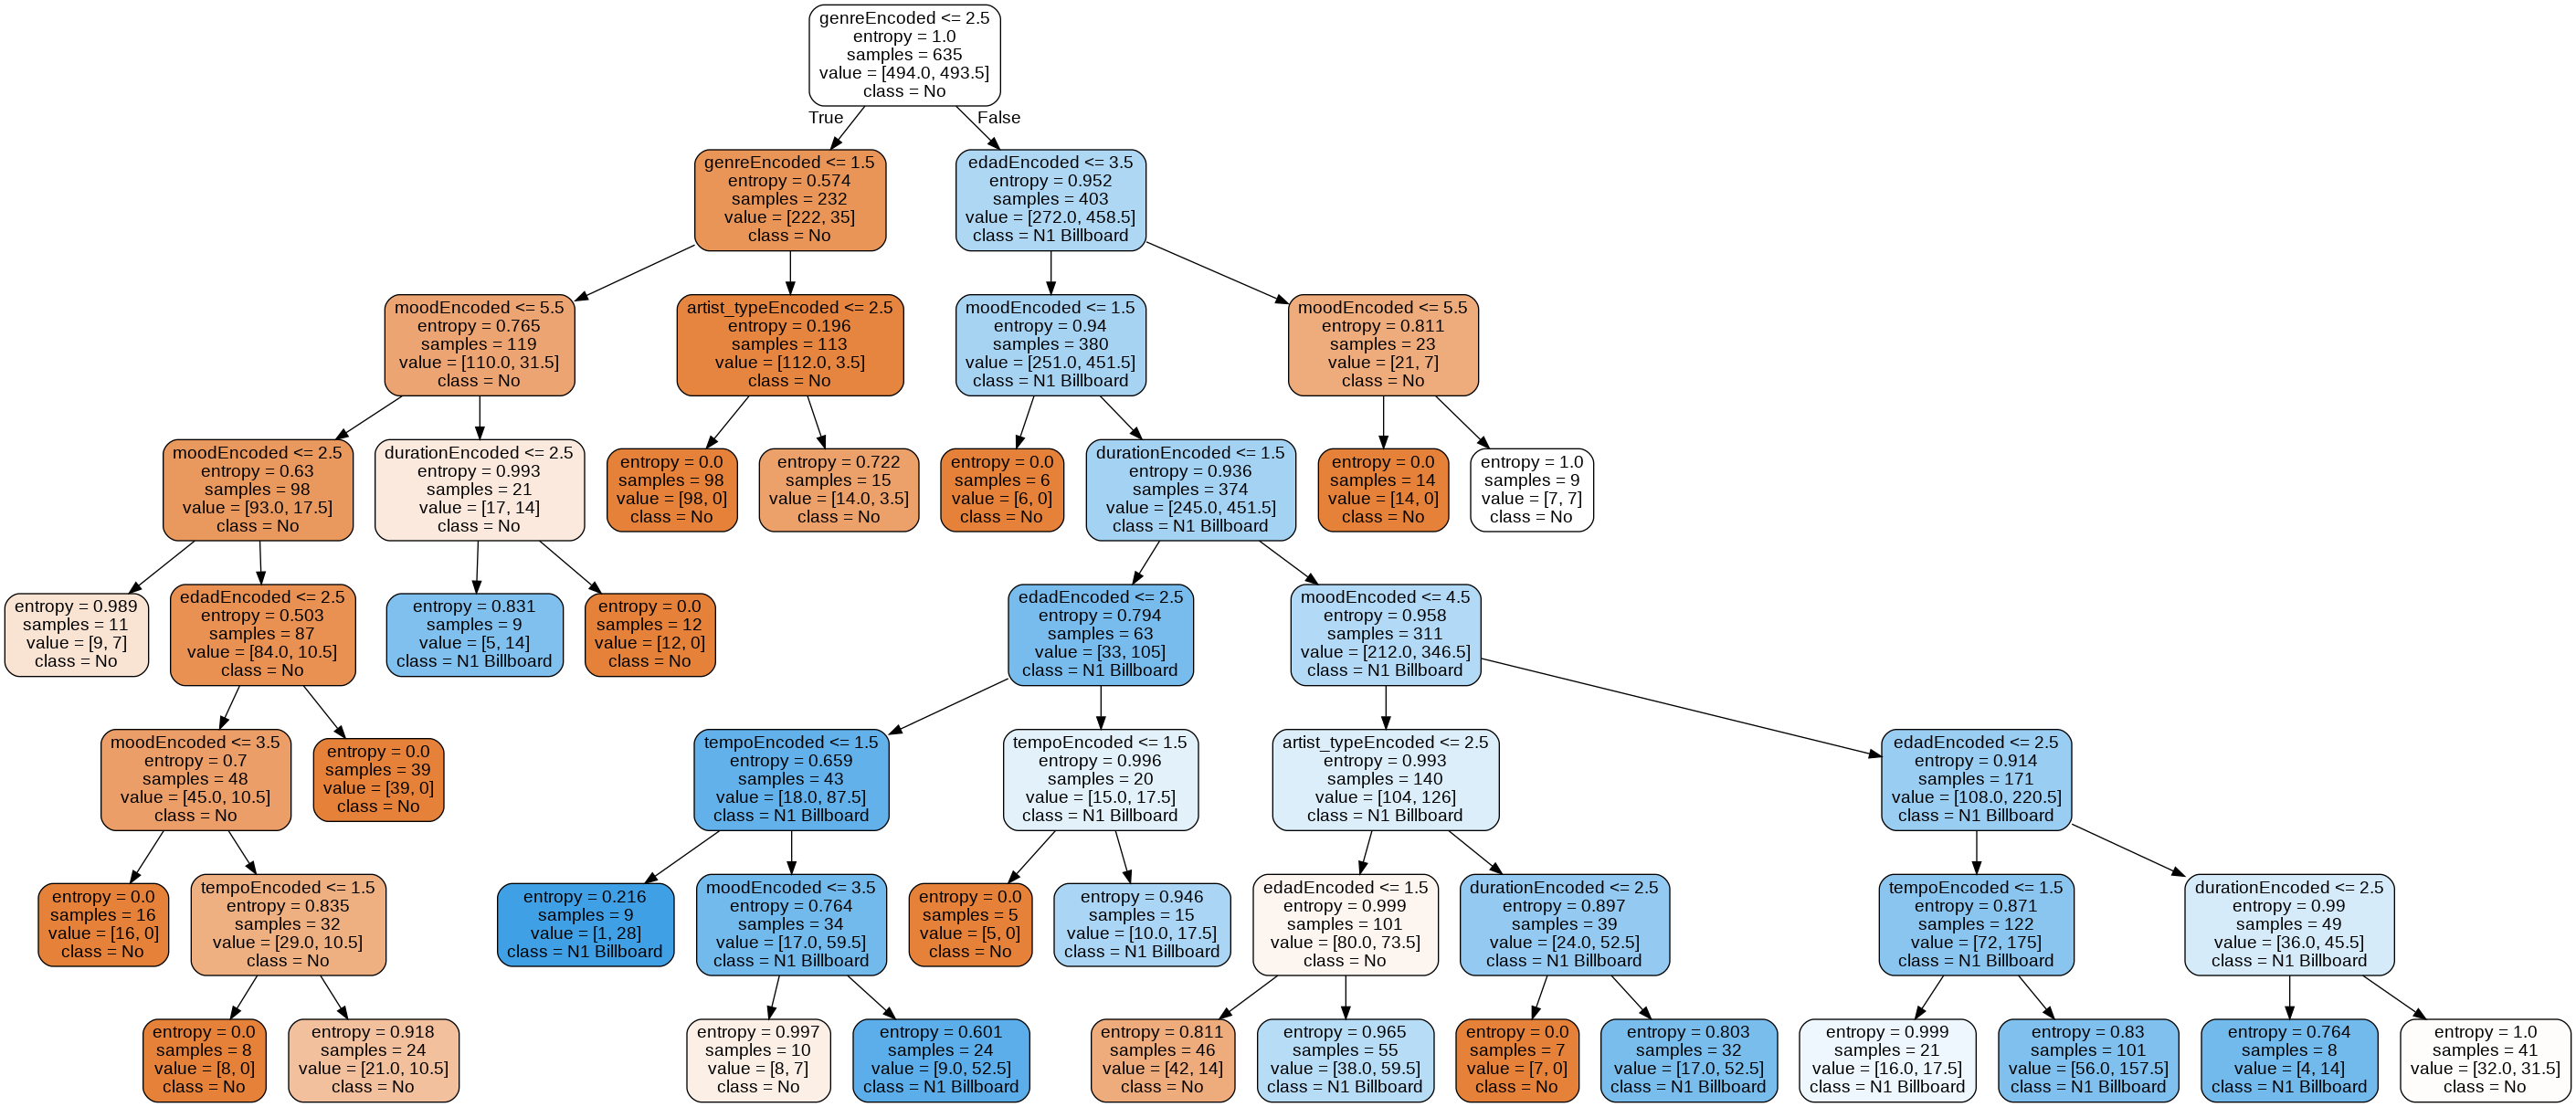

In [ ]:
#Convertir el archivo .dot a png para poder visualizarlo
check_call(['dot', 
            '-Tpng', 
            '/content/drive/My Drive/Colab Notebooks/Libro_AprendeML/tree1.dot',
            '-o',
            '/content/drive/My Drive/Colab Notebooks/Libro_AprendeML/tree1.png'])

PImage('/content/drive/My Drive/Colab Notebooks/Libro_AprendeML/tree1.png')

In [ ]:
#Precisión alcanzada por el árbol

acc_decision_tree = round(decision_tree.score(x_train, y_train) * 100, 2)
print(acc_decision_tree)

71.81


In [ ]:
#Predecir artista Camila Cabello con Havana #1 en 2017
x_test = pd.DataFrame(columns=('top', 
                               'moodEncode', 
                               'tempoEncoded', 
                               'genreEncoded', 
                               'artist_typeEncoded',
                               'edad_encoded',
                               'durationEncoded'))

x_test.loc[0] = (1,5,2,4,1,0,3)
y_pred = decision_tree.predict(x_test.drop(['top'], axis=1))
print('Predicción: ', str(y_pred))
y_proba = decision_tree.predict_proba(x_test.drop(['top'], axis=1))
print('Probabilidad de acierto: ', str(np.round(y_proba[0][y_pred] * 100, 2)) + '%')

Predicción:  [1]
Probabilidad de acierto:  [73.77]%


In [ ]:
#Predecir Imagine Dragons Believer #42
x_test = pd.DataFrame(columns=('top', 
                               'moodEncode', 
                               'tempoEncoded', 
                               'genreEncoded', 
                               'artist_typeEncoded',
                               'edad_encoded',
                               'durationEncoded'))

x_test.loc[0] = (0,4,2,1,3,2,3)
y_pred = decision_tree.predict(x_test.drop(['top'], axis=1))
print('Predicción: ', str(y_pred))
y_proba = decision_tree.predict_proba(x_test.drop(['top'], axis=1))
print('Probabilidad de acierto: ', str(np.round(y_proba[0][y_pred] * 100, 2)) + '%')

Predicción:  [0]
Probabilidad de acierto:  [66.67]%
